In [1]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
import sys
sys.path.append('/glade/u/home/linnia/ctsm6_ppe/')
from utils.pyfunctions import *
utils_path = '/glade/u/home/linnia/ctsm6_ppe/utils/'


2025-05-12 16:54:47.228760: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-12 16:54:48.371990: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747090488.671843   11002 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747090488.809353   11002 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-12 16:54:49.718499: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='20GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    account='P93300041', # Input your project ID here
    walltime='16:00:00', # Amount of wall time
    #interface='ib0', # Interface to use
)

# Scale up
cluster.scale(25)

# Setup your client
client = Client(cluster)

In [42]:
client.shutdown()

### setup

In [3]:
def get_biome_param_names(b, u_params, pft_params):
    
    with open(utils_path+"/biome_configs.pkl", "rb") as f:
        biome_configs = pickle.load(f)

    param_names = list(u_params)
    for pft in biome_configs[b]['pfts']:
        pft_param_names = [f"{param}_{pft}" for param in pft_params]
        param_names.extend(pft_param_names)

    return param_names

In [4]:
#======================== set up ============================
# get parameter information
with open(utils_dir+"/param_names.pkl", "rb") as f:
    param_info = pickle.load(f)
u_params = param_info['u_params']
pft_params = param_info['pft_params']

# get biome information
with open(utils_dir+"/biome_configs.pkl", "rb") as f:
    biome_configs = pickle.load(f)

# get default parameter set and reset some settings of default parameters
default_params = pd.read_csv('default_params_norm.csv', index_col=False)
default_params.loc[0, ['jmaxb1']] = [0.4]
default_params.loc[0, ['theta_cj']] = [0.7]
default_params.loc[0, ['upplim_destruct_metamorph']] = [1]
default_params.loc[0, ['xl_12']] = [0]

# Build universal_set tensor
universal_set = tf.constant(default_params[u_params].iloc[[0]].to_numpy(),dtype=tf.float64)

x_default = tf.constant(default_params.drop(columns=u_params).iloc[[0]].to_numpy(), dtype=tf.float64)


2025-05-12 16:56:33.374949: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [15]:
# get observations 
obs_biome = xr.open_dataset('calibration_obsStatistics_sudokuBiomes.nc')

In [16]:
paths = {
    'lai': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_biomelai_compiled/',
    'gpp': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_biomegpp_compiled/',
    'biomass': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_biomebiomass_compiled/'
}

biomes = [1,2,3,4,5,6,7,8,9,10,11,12,13]
param_indices = []
targets = []
stdevs = []
emulators = []  

for b in biomes:
    biome_name = biome_configs[b]['name']
    param_names = get_biome_param_names(b,u_params,pft_params)
    param_ix = [default_params.columns.get_loc(p)for p in param_names]
    
    param_indices.append(param_ix)
    param_indices.append(param_ix)
    param_indices.append(param_ix)
    
    targets.extend([
        tf.convert_to_tensor(obs_biome.LAI_mean.isel(biome=b).values, dtype=tf.float64),
        tf.convert_to_tensor(obs_biome.GPP_mean.isel(biome=b).values, dtype=tf.float64),
        tf.convert_to_tensor(obs_biome.TVC_mean.isel(biome=b).values, dtype=tf.float64)
    ])
    stdevs.extend([
        tf.convert_to_tensor(obs_biome.LAI_stdev.isel(biome=b).values, dtype=tf.float64),
        tf.convert_to_tensor(obs_biome.GPP_stdev.isel(biome=b).values, dtype=tf.float64),
        tf.convert_to_tensor(obs_biome.TVC_stdev.isel(biome=b).values, dtype=tf.float64)
    ])

    emulators.extend([
        tf.saved_model.load(f"{paths['lai']}{biome_name}"),
        tf.saved_model.load(f"{paths['gpp']}{biome_name}"),
        tf.saved_model.load(f"{paths['biomass']}{biome_name}")
    ])
    
targets = tf.stack(targets, axis=0)  
stdevs = tf.stack(stdevs, axis=0)   


In [17]:
# ——— for fast graph execution ———
lengths = [len(arr) for arr in param_indices]     # list of Python ints

emulator_array = []
for m,input_dim in zip(emulators, lengths):
    sig = tf.TensorSpec([None, input_dim], tf.float64)
    f = tf.function(lambda X, _m=m: _m.compiled_predict_f(X)[0], input_signature=[sig])
    emulator_array.append(f)

### Functions

In [8]:

@tf.function
def optimization_step_batch(x, universal_set, emulator_array, param_indices, optimizer, x_default, barrier_strength=1, lambda_penalty=0.01):
    with tf.GradientTape() as tape:
        batch = tf.shape(x)[0]
        u_tiled = tf.tile(universal_set, [batch, 1])   
        x_full = tf.concat([u_tiled, x], axis=1)
        per_model_losses = []
        
        # loop over metrics and biomes in stacked 1D arrays. 
        for i in range(len(emulator_array)):
            model   = emulator_array[i]

            target = tf.reshape(targets[i], (1, -1))
            stdev = tf.reshape(stdevs[i], (1, -1))
            target_tiled = tf.tile(target, [batch, 1])
            stdev_tiled = tf.tile(stdev, [batch, 1])
        
            ix  = param_indices[i]          
            x_biome = tf.gather(x_full, ix, axis=1)
            y_pred = model(x_biome)
            z = tf.abs((y_pred - target_tiled)/stdev_tiled)

            if epsilon is not None: # if biome/variable zscore is < epsilon, it no longer contributes to loss
                mask = tf.cast(z > epsilon, tf.float64)
                loss_b = tf.reduce_sum(mask * tf.square(z), axis=1)
            else:
                loss_b = tf.reduce_sum(tf.square(z), axis=1)
            
            # size [batch]
            per_model_losses.append(loss_b)
            
        loss_per_sample = tf.add_n(per_model_losses)
        data_loss = tf.reduce_mean(loss_per_sample) # overall scalar loss = mean of the batch
        max_z = tf.sqrt(tf.reduce_max(loss_per_sample)) # worst individual biome/init zscore

        # Penalty for moving from default
        # sum over the parameter‐axis (axis=1) → shape [batch]
        x_default_tiled = tf.tile(x_default, [batch, 1])
        sum_abs = tf.reduce_sum(tf.abs(x - x_default_tiled), axis=1)
        penalty = tf.reduce_mean(sum_abs) # mean of batch

        ratio = penalty / lambda_penalty
        factor = tf.maximum(ratio, 1.0) # if the penalty ==lambda, it no longer impacts loss
        total_loss = data_loss * factor
        
        # penalty for being close to/outside of bounds (0,1)
        barrier = tf.reduce_mean(1.0 / (x + 1e-6) + 1.0 / (1.0 - x + 1e-6))
        total_loss = total_loss * (1.0 + barrier_strength * barrier)
        
    grads = tape.gradient(total_loss, [x])
    optimizer.apply_gradients(zip(grads, [x]))
    x.assign(tf.clip_by_value(x, 0.0, 1.0))
    return total_loss, max_z, data_loss, factor, barrier_strength*barrier

In [9]:

def run_optimization(x, universal_set, emulator_array, param_indices, x_default, maxiter, lr, lr_decay_steps, checkpoint_N, checkpoint_dir, epsilon, barrier_strength, lambda_penalty=0.0):
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=lr,
        decay_steps=lr_decay_steps,
        decay_rate=0.5,
        staircase=True)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    history_total_loss = []
    history_max_z = []
    history_data_loss = []
    history_penalty = []
    history_barrier = []
    
    for step in range(maxiter):

        total_loss, max_z, data_loss, penalty, barrier_loss = optimization_step_batch(x, universal_set, emulator_array, param_indices, optimizer, x_default, barrier_strength, lambda_penalty)

        # log
        history_total_loss.append(total_loss.numpy())
        history_max_z.append(max_z.numpy())
        history_data_loss.append(data_loss.numpy())
        history_penalty.append(penalty.numpy())
        history_barrier.append(barrier_loss.numpy())

        # print updates to screen
        if step % 10 == 0:
            tf.print(f"Step {step:03d}: total={total_loss:.6f} max_z={max_z:.6f}")
    
        # Save a checkpoint every N iterations
        if step % checkpoint_N == 0:
            checkpoint = {
                'step': step,
                'params': x,
                'loss': total_loss,
            }
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_step_{step}.pkl')
            with open(checkpoint_path, 'wb') as f:
                pickle.dump(checkpoint, f)
                
        # early stopping
        if tf.reduce_max(max_z) <= epsilon:
            print(f"Converged at step {step}")
            tf.print(f"Step {step:03d}: total={total_loss:.6f} max_z={max_z:.6f}")
            break
    
    x_opt = x.numpy()
    logs = {
        'total_loss': history_total_loss,
        'max_z': history_max_z,
        'data_loss': history_data_loss,
        'penalty': history_penalty,
        'barrier': history_barrier
    }
    
    return x_opt, logs

### initialization

In [10]:
# initialization: sample from normal priors around default
pft_cols     = [c for c in default_params.columns if c not in u_params]
default_pftparams = default_params[pft_cols].iloc[0].values   

n_inits = 1000
sigma   = 0.1   # spread of your normal draws

np.random.seed(42)   
x0 = np.random.normal(loc=default_pftparams,
                      scale=sigma,
                      size=(n_inits, default_pftparams.size))

# enforce bounds [0,1]
x0 = np.clip(x0, 0.0, 1.0)

x_init = tf.Variable(
    tf.constant(x0, dtype=tf.float64),
    trainable=True,
    name="x"
)

In [9]:
# =========================== save ======================================
n_inits = np.shape(x0)[0]
uset_tiled = np.tile(default_params[u_params].values[0], (n_inits,1))
init_sets = np.concatenate([uset_tiled,x0],axis=1)
init_paramsets = pd.DataFrame(init_sets,columns=default_params.columns.values)

outfile = 'init_sets_defaultPrior.csv'
init_paramsets.to_csv(outfile,index=False)

In [9]:
with open("./checkpoints_PhilosophyA_v2/checkpoint_step_1490.pkl", "rb") as f:
    c0 = pickle.load(f)

x_init = tf.Variable(
    tf.constant(c0['params'], dtype=tf.float64),
    trainable=True,
    name="x"
)

### calibration

In [11]:
%%time
# Run optimization
epsilon = 1
lr = 1e-2
maxiter=2000
lr_decay_steps = 300
checkpoint_N = 50
checkpoint_dir = './checkpoints_close2default/'
lambda_penalty = 14 # worst sum of delta from default you will tolerate
barrier_strength = 0 # clipping is on

x_opt, logs = run_optimization(x_init, universal_set, emulator_array, param_indices, x_default, 
                               maxiter, lr, lr_decay_steps, checkpoint_N, checkpoint_dir, epsilon, barrier_strength, lambda_penalty)

Step 000: total=646.250177 max_z=33.128945
Step 010: total=162.211629 max_z=18.943477
Step 020: total=69.294109 max_z=10.463944
Step 030: total=47.807390 max_z=8.284022
Step 040: total=37.112778 max_z=7.232262
Step 050: total=27.789473 max_z=6.164183
Step 060: total=21.924976 max_z=5.544114
Step 070: total=19.075445 max_z=5.273494
Step 080: total=17.092456 max_z=5.011563
Step 090: total=15.464597 max_z=4.959813
Step 100: total=14.133277 max_z=4.507978
Step 110: total=13.010527 max_z=4.492766
Step 120: total=12.490657 max_z=4.303377
Step 130: total=11.965451 max_z=4.322492
Step 140: total=11.503239 max_z=4.298335
Step 150: total=10.926380 max_z=4.172717
Step 160: total=10.474916 max_z=4.033149
Step 170: total=10.018041 max_z=4.023312
Step 180: total=9.689678 max_z=3.930436
Step 190: total=9.229795 max_z=3.925336
Step 200: total=8.734536 max_z=3.808299
Step 210: total=8.414895 max_z=3.724159
Step 220: total=8.034463 max_z=3.700880
Step 230: total=7.824038 max_z=3.613001
Step 240: total=7

In [12]:
# =========================== save ======================================
n_inits = np.shape(x_opt)[0]
uset_tiled = np.tile(default_params[u_params].values[0], (n_inits,1))
opt_sets = np.concatenate([uset_tiled,x_opt],axis=1)
calibrated_paramsets = pd.DataFrame(opt_sets,columns=default_params.columns.values)

outfile = checkpoint_dir+'calibrated_sets_defaultPrior_lambda14_051225.csv'
calibrated_paramsets.to_csv(outfile,index=False)

### plot convergence logs

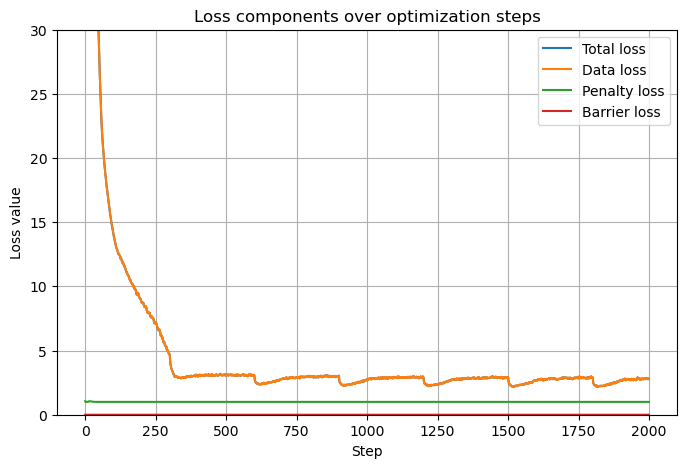

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(logs['total_loss'], label='Total loss')
plt.plot(logs['data_loss'], label='Data loss')
plt.plot(logs['penalty'], label='Penalty loss')
plt.plot(logs['barrier'], label='Barrier loss')
plt.xlabel('Step')
plt.ylabel('Loss value')
plt.legend()
plt.grid(True)
plt.title('Loss components over optimization steps')
plt.ylim(0,30)
plt.show()


In [14]:
d_tiled = np.tile(default_params.drop(columns=u_params).values[0], (n_inits,1))
np.sum(np.abs(x_opt - d_tiled),axis=1)

array([14.55830378, 13.91726889, 14.49504657, 13.57930507, 13.93896848,
       14.15209582, 13.57923877, 13.83154002, 14.41087583, 14.14479884,
       14.62108081, 13.91409517, 13.9615816 , 13.63335982, 13.87481127,
       15.68755695, 13.14257339, 14.17332967, 12.99066776, 13.8622669 ,
       14.02283579, 14.42589635, 14.0362117 , 14.1276838 , 14.46254419,
       14.08744118, 13.59385237, 13.83578363, 13.53348825, 14.18905   ,
       13.13486857, 13.73619341, 14.5189674 , 13.64237303, 14.28001506,
       14.10497261, 13.78435638, 12.99228053, 13.55475406, 13.90592512,
       13.80265976, 15.08871811, 13.80157981, 14.37584726, 13.71077068,
       14.34645547, 13.98486128, 13.71064577, 14.36089799, 13.46408486,
       13.29523378, 14.66415266, 13.86308516, 13.6323965 , 14.33217053,
       13.48918217, 13.42344359, 14.30779222, 14.40018485, 13.82211137,
       14.29907779, 14.06429805, 13.58327682, 13.61274891, 13.71735354,
       13.39364628, 13.10460253, 14.10590205, 14.31935252, 14.20

### Plot posteriors

In [ ]:
full_calibrated_paramsets = pd.read_csv('calibrated_sets_unifRandom.csv')

In [ ]:
# Define LEAP colors
leap_colors = ['#B9D9EB', '#00796B', '#012169']

# Prepare data
pft = 4
pft_param_names = [f"{param}_{pft}" for param in pft_params]
data = full_calibrated_paramsets[pft_param_names]

n = len(pft_param_names)

# Set plot-wide styles
plt.rcParams.update({
    'font.size': 10,         # Font size
    'axes.labelsize': 12,    # Axis label size
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8,
    'axes.linewidth': 0.8,   # Thin frame lines
    'savefig.dpi': 300,
})

fig, axes = plt.subplots(n, n, figsize=(2*n, 2*n))  # Larger, scalable size

for i in range(n):
    for j in range(n):
        ax = axes[i, j]
        if i == j:
            # 1D histogram on the diagonal
            ax.hist(data[pft_param_names[i]], bins=50, color=leap_colors[2], alpha=0.7)
            ax.axvline(default_params[pft_param_names[i]].values)
            ax.set_xlim([0,1])
        else:
            # 2D hexbin on the off-diagonals
            hb = ax.hexbin(
                data[pft_param_names[j]],
                data[pft_param_names[i]],
                gridsize=50,
                #cmap='Blues',
                vmin=0,
                vmax=20,
                mincnt=1,           # Only show bins with data
                linewidths=0
            )
            # Fix hexbin color to LEAP navy color
            #hb.set_cmap('Blues')
            #hb.set_array(hb.get_array()*0+1)  # Uniform color intensity
            #hb.set_edgecolor('none')
            #hb.set_facecolor(leap_colors[2])  # Dark navy
            ax.axvline(default_params[pft_param_names[j]].values)
            ax.axhline(default_params[pft_param_names[i]].values)
            #ax.set_ylim([0,1])
            #ax.set_xlim([0,1])

        # Clean ticks
        if i < n-1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(pft_param_names[j], fontsize=10)
        if j > 0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(pft_param_names[i], fontsize=10)

plt.tight_layout(pad=0.5)
#plt.savefig('./figs/hexbin_scattermatrix_pftparams_pft'+str(pft)+'.png', dpi = 300)

In [15]:
logs['penalty']

[39.19748610423464,
 34.74208605643806,
 31.0533170457477,
 28.07848845754855,
 25.75201064567405,
 24.002948467894115,
 22.761878489796153,
 21.962020944154865,
 21.538431862164845,
 21.431126831175046,
 21.586122228656986,
 21.95586542086044,
 22.49958441426443,
 23.181805973609077,
 23.971795912696216,
 24.845295042472788,
 25.78029721367061,
 26.758748107154787,
 27.76520428706409,
 28.787663962554305,
 29.818780795559505,
 30.849958417824514,
 31.877034060858648,
 32.89653630142642,
 33.904920581228126,
 34.900303829869735,
 35.88036374907937,
 36.842961020215874,
 37.785867689159446,
 38.70851073808008,
 39.60653624960008,
 40.47950465389614,
 41.32416071826179,
 42.14215547319547,
 42.93285113408188,
 43.69410084846617,
 44.42665008976809,
 45.12562522915323,
 45.794447964061895,
 46.43065652785542,
 47.03647134455201,
 47.61176166825982,
 48.15596891307426,
 48.67429188063457,
 49.16779784718529,
 49.63957858472188,
 50.0912600653993,
 50.524037652200434,
 50.939122228800066,
 

In [16]:
60/20

3.0

In [17]:
3/20

0.15